# Dataset

In [1]:
!gdown 194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj

Downloading...
From (original): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj
From (redirected): https://drive.google.com/uc?id=194DqJkUjjtlUCp7Sd2DkXgwu7SuBFsrj&confirm=t&uuid=29efeda4-0f05-4f56-b6e0-6a81547d4877
To: /kaggle/working/celeba_hq_256.zip
100%|█████████████████████████████████████████| 297M/297M [00:01<00:00, 182MB/s]


In [2]:
!unzip celeba_hq_256.zip

Archive:  celeba_hq_256.zip
  inflating: celeba_hq_256/00000.jpg  
  inflating: celeba_hq_256/00001.jpg  
  inflating: celeba_hq_256/00002.jpg  
  inflating: celeba_hq_256/00003.jpg  
  inflating: celeba_hq_256/00004.jpg  
  inflating: celeba_hq_256/00005.jpg  
  inflating: celeba_hq_256/00006.jpg  
  inflating: celeba_hq_256/00007.jpg  
  inflating: celeba_hq_256/00008.jpg  
  inflating: celeba_hq_256/00009.jpg  
  inflating: celeba_hq_256/00010.jpg  
  inflating: celeba_hq_256/00011.jpg  
  inflating: celeba_hq_256/00012.jpg  
  inflating: celeba_hq_256/00013.jpg  
  inflating: celeba_hq_256/00014.jpg  
  inflating: celeba_hq_256/00015.jpg  
  inflating: celeba_hq_256/00016.jpg  
  inflating: celeba_hq_256/00017.jpg  
  inflating: celeba_hq_256/00018.jpg  
  inflating: celeba_hq_256/00019.jpg  
  inflating: celeba_hq_256/00020.jpg  
  inflating: celeba_hq_256/00021.jpg  
  inflating: celeba_hq_256/00022.jpg  
  inflating: celeba_hq_256/00023.jpg  
  inflating: celeba_hq_256/00024.jpg

In [3]:
import os

file_names = os.listdir('./celeba_hq_256')
img_paths = ['./celeba_hq_256/' + file_name for file_name in file_names]
len(img_paths)

30000

In [4]:
import random

sample_size = int(len(img_paths) * 0.9)
train_imgpaths = random.sample(img_paths, sample_size)
val_imgpaths = [img_path for img_path in img_paths if img_path not in train_imgpaths]
train_imgpaths = img_paths[:100]
val_imgpaths = img_paths[:50]

In [5]:
len(train_imgpaths), len(val_imgpaths)

(100, 50)

In [6]:
import numpy as np

def bbox2mask(img_shape, bbox, dtype='uint8'):
    """
    Generate mask in ndarray from bbox.
    bbox (tuple[int]): Configuration tuple, (top, left, height, width)
    """

    height, width = img_shape[:2]

    mask = np.zeros((height, width, 1), dtype=dtype)
    mask[bbox[0]:bbox[0] + bbox[2], bbox[1]:bbox[1] + bbox[3], :] = 1

    return mask

In [7]:
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class InpaintingDataset(Dataset):
    def __init__(self, img_paths, image_size=[256, 256]):
        self.img_paths = img_paths
        self.tfs = transforms.Compose([
                transforms.Resize((image_size[0], image_size[1])),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5, 0.5])
        ])
        self.image_size = image_size

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        img = self.tfs(img)
        mask = self.get_mask()
        cond_image = img*(1. - mask) + mask*torch.randn_like(img)
        mask_img = img*(1. - mask) + mask
        return {
            'gt_image': img,
            'cond_image': cond_image,
            'mask_image': mask_img,
            'mask': mask,
            'path': img_path
        }

    def __len__(self):
        return len(self.img_paths)

    def get_mask(self):
        # Center mask
        h, w = self.image_size
        mask = bbox2mask(self.image_size, (h//4, w//4, h//4, w//4))
        return torch.from_numpy(mask).permute(2,0,1)

In [8]:
train_dataset = InpaintingDataset(train_imgpaths)
val_dataset = InpaintingDataset(val_imgpaths)

In [9]:
sample = next(iter(train_dataset))

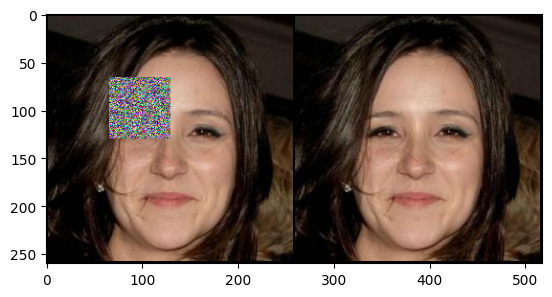

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid([sample['cond_image'], sample['gt_image']])
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [11]:
import multiprocessing
batch_size = 16
num_workers = multiprocessing.cpu_count() // 2

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2
)

In [12]:
len(train_loader)

6

# Training

In [13]:
! pip install -q torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 10.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.3 MB/s eta 0:00:00


In [14]:
from torchcfm.models.unet import UNetModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetModel(dim=(3, 256, 256), num_channels=32, num_res_blocks=1)

import torch.nn as nn
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
    
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Using 2 GPUs


In [15]:
n_epochs = 1000

from tqdm import tqdm
for epoch in range(n_epochs):
    losses = []
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()

        x1 = data['gt_image'].to(device)
        mask = data['mask'].to(device)

        x0 = torch.randn_like(x1).to(device)
        x_noise = (1.0-mask)*x1 + mask*x0

        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)

        xt = t * x1 + (1 - t) * x_noise
        ut = x1 - x_noise

        t = t.squeeze()

        x_cond = xt*mask + (1.0-mask)*x1

        vt = model(t, x_cond)

        loss = torch.mean(((vt - ut) ** 2)*mask)

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

6it [00:04,  1.42it/s]

epoch: 0, loss: 0.07142



6it [00:02,  2.92it/s]

epoch: 1, loss: 0.04677



6it [00:02,  2.89it/s]

epoch: 2, loss: 0.03082



6it [00:02,  2.86it/s]

epoch: 3, loss: 0.01817



6it [00:02,  2.86it/s]

epoch: 4, loss: 0.01629



6it [00:02,  2.90it/s]

epoch: 5, loss: 0.01372



6it [00:02,  2.82it/s]

epoch: 6, loss: 0.01157



6it [00:02,  2.90it/s]

epoch: 7, loss: 0.01274



6it [00:02,  2.83it/s]

epoch: 8, loss: 0.009154



6it [00:02,  2.78it/s]

epoch: 9, loss: 0.008883



6it [00:02,  2.84it/s]

epoch: 10, loss: 0.009229



6it [00:02,  2.85it/s]

epoch: 11, loss: 0.007108



6it [00:02,  2.74it/s]

epoch: 12, loss: 0.006622



6it [00:02,  2.82it/s]

epoch: 13, loss: 0.007305



6it [00:02,  2.81it/s]

epoch: 14, loss: 0.008145



6it [00:02,  2.31it/s]

epoch: 15, loss: 0.00624



6it [00:02,  2.82it/s]

epoch: 16, loss: 0.007379



6it [00:02,  2.79it/s]

epoch: 17, loss: 0.006477



6it [00:02,  2.68it/s]

epoch: 18, loss: 0.005677



6it [00:02,  2.76it/s]

epoch: 19, loss: 0.006925



6it [00:02,  2.80it/s]

epoch: 20, loss: 0.006421



6it [00:02,  2.76it/s]

epoch: 21, loss: 0.006639



6it [00:02,  2.79it/s]

epoch: 22, loss: 0.006168



6it [00:02,  2.82it/s]

epoch: 23, loss: 0.006657



6it [00:02,  2.74it/s]

epoch: 24, loss: 0.006273



6it [00:02,  2.75it/s]

epoch: 25, loss: 0.005769



6it [00:02,  2.62it/s]

epoch: 26, loss: 0.004885



6it [00:02,  2.69it/s]

epoch: 27, loss: 0.004329



6it [00:02,  2.74it/s]

epoch: 28, loss: 0.00567



6it [00:02,  2.75it/s]

epoch: 29, loss: 0.006112



6it [00:02,  2.73it/s]

epoch: 30, loss: 0.004799



6it [00:02,  2.71it/s]

epoch: 31, loss: 0.004888



6it [00:02,  2.76it/s]

epoch: 32, loss: 0.005163



6it [00:02,  2.41it/s]

epoch: 33, loss: 0.004494



6it [00:02,  2.73it/s]

epoch: 34, loss: 0.004375



6it [00:02,  2.66it/s]

epoch: 35, loss: 0.005373



6it [00:02,  2.75it/s]

epoch: 36, loss: 0.006194



6it [00:02,  2.69it/s]

epoch: 37, loss: 0.004633



6it [00:02,  2.72it/s]

epoch: 38, loss: 0.003873



6it [00:02,  2.71it/s]

epoch: 39, loss: 0.003715



6it [00:02,  2.47it/s]

epoch: 40, loss: 0.004392



6it [00:02,  2.66it/s]

epoch: 41, loss: 0.005398



6it [00:02,  2.66it/s]

epoch: 42, loss: 0.004133



6it [00:02,  2.67it/s]

epoch: 43, loss: 0.004907



6it [00:02,  2.66it/s]

epoch: 44, loss: 0.00383



6it [00:02,  2.65it/s]

epoch: 45, loss: 0.004089



6it [00:02,  2.69it/s]

epoch: 46, loss: 0.003664



6it [00:02,  2.64it/s]

epoch: 47, loss: 0.004824



6it [00:02,  2.64it/s]

epoch: 48, loss: 0.003769



6it [00:02,  2.64it/s]

epoch: 49, loss: 0.005979



6it [00:02,  2.57it/s]

epoch: 50, loss: 0.003837



6it [00:02,  2.60it/s]

epoch: 51, loss: 0.004594



6it [00:02,  2.61it/s]

epoch: 52, loss: 0.003681



6it [00:02,  2.51it/s]

epoch: 53, loss: 0.005333



6it [00:02,  2.10it/s]

epoch: 54, loss: 0.004121



6it [00:02,  2.59it/s]

epoch: 55, loss: 0.002753



6it [00:02,  2.61it/s]

epoch: 56, loss: 0.004449



6it [00:02,  2.61it/s]

epoch: 57, loss: 0.003981



6it [00:02,  2.62it/s]

epoch: 58, loss: 0.0046



6it [00:02,  2.66it/s]

epoch: 59, loss: 0.004087



6it [00:02,  2.64it/s]

epoch: 60, loss: 0.003015



6it [00:02,  2.60it/s]

epoch: 61, loss: 0.00406



6it [00:02,  2.69it/s]

epoch: 62, loss: 0.003345



6it [00:02,  2.65it/s]

epoch: 63, loss: 0.003986



6it [00:02,  2.66it/s]

epoch: 64, loss: 0.004702



6it [00:02,  2.70it/s]

epoch: 65, loss: 0.0047



6it [00:02,  2.64it/s]

epoch: 66, loss: 0.004302



6it [00:02,  2.48it/s]

epoch: 67, loss: 0.003459



6it [00:02,  2.68it/s]

epoch: 68, loss: 0.005179



6it [00:02,  2.65it/s]

epoch: 69, loss: 0.005929



6it [00:02,  2.74it/s]

epoch: 70, loss: 0.003629



6it [00:02,  2.65it/s]

epoch: 71, loss: 0.00572



6it [00:02,  2.58it/s]

epoch: 72, loss: 0.003942



6it [00:02,  2.67it/s]

epoch: 73, loss: 0.00452



6it [00:02,  2.68it/s]

epoch: 74, loss: 0.003648



6it [00:02,  2.65it/s]

epoch: 75, loss: 0.004668



6it [00:02,  2.67it/s]

epoch: 76, loss: 0.004766



6it [00:02,  2.19it/s]

epoch: 77, loss: 0.004121



6it [00:02,  2.63it/s]

epoch: 78, loss: 0.003305



6it [00:02,  2.65it/s]

epoch: 79, loss: 0.004064



6it [00:02,  2.59it/s]

epoch: 80, loss: 0.002853



6it [00:02,  2.63it/s]

epoch: 81, loss: 0.006112



6it [00:02,  2.62it/s]

epoch: 82, loss: 0.00519



6it [00:02,  2.68it/s]

epoch: 83, loss: 0.004268



6it [00:02,  2.67it/s]

epoch: 84, loss: 0.00328



6it [00:02,  2.70it/s]

epoch: 85, loss: 0.003925



6it [00:02,  2.64it/s]

epoch: 86, loss: 0.003683



6it [00:02,  2.65it/s]

epoch: 87, loss: 0.002922



6it [00:02,  2.64it/s]

epoch: 88, loss: 0.004309



6it [00:02,  2.67it/s]

epoch: 89, loss: 0.003843



6it [00:02,  2.63it/s]

epoch: 90, loss: 0.002638



6it [00:02,  2.70it/s]

epoch: 91, loss: 0.005624



6it [00:02,  2.70it/s]

epoch: 92, loss: 0.004492



6it [00:02,  2.64it/s]

epoch: 93, loss: 0.003572



6it [00:02,  2.55it/s]

epoch: 94, loss: 0.004335



6it [00:02,  2.62it/s]

epoch: 95, loss: 0.00377



6it [00:02,  2.71it/s]

epoch: 96, loss: 0.003462



6it [00:02,  2.69it/s]

epoch: 97, loss: 0.003926



6it [00:02,  2.19it/s]

epoch: 98, loss: 0.003155



6it [00:02,  2.64it/s]

epoch: 99, loss: 0.003214



6it [00:02,  2.65it/s]

epoch: 100, loss: 0.002921



6it [00:02,  2.62it/s]

epoch: 101, loss: 0.003006



6it [00:02,  2.65it/s]

epoch: 102, loss: 0.002849



6it [00:02,  2.64it/s]

epoch: 103, loss: 0.003543



6it [00:02,  2.64it/s]

epoch: 104, loss: 0.003969



6it [00:02,  2.70it/s]

epoch: 105, loss: 0.003937



6it [00:02,  2.69it/s]

epoch: 106, loss: 0.004551



6it [00:02,  2.55it/s]

epoch: 107, loss: 0.00303



6it [00:02,  2.58it/s]

epoch: 108, loss: 0.002905



6it [00:02,  2.64it/s]

epoch: 109, loss: 0.003922



6it [00:02,  2.67it/s]

epoch: 110, loss: 0.003578



6it [00:02,  2.68it/s]

epoch: 111, loss: 0.003097



6it [00:02,  2.63it/s]

epoch: 112, loss: 0.003396



6it [00:02,  2.65it/s]

epoch: 113, loss: 0.002631



6it [00:02,  2.67it/s]

epoch: 114, loss: 0.00296



6it [00:02,  2.63it/s]

epoch: 115, loss: 0.003821



6it [00:02,  2.67it/s]

epoch: 116, loss: 0.002979



6it [00:02,  2.66it/s]

epoch: 117, loss: 0.003354



6it [00:02,  2.67it/s]

epoch: 118, loss: 0.002063



6it [00:02,  2.18it/s]

epoch: 119, loss: 0.00303



6it [00:02,  2.70it/s]

epoch: 120, loss: 0.002807



6it [00:02,  2.53it/s]

epoch: 121, loss: 0.004032



6it [00:02,  2.66it/s]

epoch: 122, loss: 0.003889



6it [00:02,  2.62it/s]

epoch: 123, loss: 0.00349



6it [00:02,  2.60it/s]

epoch: 124, loss: 0.003238



6it [00:02,  2.62it/s]

epoch: 125, loss: 0.00356



6it [00:02,  2.68it/s]

epoch: 126, loss: 0.002472



6it [00:02,  2.66it/s]

epoch: 127, loss: 0.003164



6it [00:02,  2.64it/s]

epoch: 128, loss: 0.003138



6it [00:02,  2.56it/s]

epoch: 129, loss: 0.004196



6it [00:02,  2.65it/s]

epoch: 130, loss: 0.003255



6it [00:02,  2.67it/s]

epoch: 131, loss: 0.002403



6it [00:02,  2.65it/s]

epoch: 132, loss: 0.002907



6it [00:02,  2.61it/s]

epoch: 133, loss: 0.003365



6it [00:02,  2.56it/s]

epoch: 134, loss: 0.003382



6it [00:02,  2.60it/s]

epoch: 135, loss: 0.00316



6it [00:02,  2.66it/s]

epoch: 136, loss: 0.00356



6it [00:02,  2.63it/s]

epoch: 137, loss: 0.004256



6it [00:02,  2.69it/s]

epoch: 138, loss: 0.002754



6it [00:02,  2.66it/s]

epoch: 139, loss: 0.003216



6it [00:02,  2.67it/s]

epoch: 140, loss: 0.002948



6it [00:02,  2.16it/s]

epoch: 141, loss: 0.002917



6it [00:02,  2.62it/s]

epoch: 142, loss: 0.00435



6it [00:02,  2.67it/s]

epoch: 143, loss: 0.003814



6it [00:02,  2.64it/s]

epoch: 144, loss: 0.003822



6it [00:02,  2.61it/s]

epoch: 145, loss: 0.003038



6it [00:02,  2.58it/s]

epoch: 146, loss: 0.003585



6it [00:02,  2.65it/s]

epoch: 147, loss: 0.002674



6it [00:02,  2.47it/s]

epoch: 148, loss: 0.003625



6it [00:02,  2.66it/s]

epoch: 149, loss: 0.002817



6it [00:02,  2.64it/s]

epoch: 150, loss: 0.002722



6it [00:02,  2.70it/s]

epoch: 151, loss: 0.002333



6it [00:02,  2.67it/s]

epoch: 152, loss: 0.002766



6it [00:02,  2.63it/s]

epoch: 153, loss: 0.003219



6it [00:02,  2.67it/s]

epoch: 154, loss: 0.002718



6it [00:02,  2.65it/s]

epoch: 155, loss: 0.003107



6it [00:02,  2.62it/s]

epoch: 156, loss: 0.002778



6it [00:02,  2.63it/s]

epoch: 157, loss: 0.002695



6it [00:02,  2.61it/s]

epoch: 158, loss: 0.00304



6it [00:02,  2.66it/s]

epoch: 159, loss: 0.002703



6it [00:02,  2.63it/s]

epoch: 160, loss: 0.003666



6it [00:02,  2.60it/s]

epoch: 161, loss: 0.003004



6it [00:02,  2.53it/s]

epoch: 162, loss: 0.002843



6it [00:02,  2.16it/s]

epoch: 163, loss: 0.002821



6it [00:02,  2.65it/s]

epoch: 164, loss: 0.004668



6it [00:02,  2.67it/s]

epoch: 165, loss: 0.00389



6it [00:02,  2.65it/s]

epoch: 166, loss: 0.002675



6it [00:02,  2.59it/s]

epoch: 167, loss: 0.003955



6it [00:02,  2.65it/s]

epoch: 168, loss: 0.003035



6it [00:02,  2.62it/s]

epoch: 169, loss: 0.002837



6it [00:02,  2.63it/s]

epoch: 170, loss: 0.003842



6it [00:02,  2.63it/s]

epoch: 171, loss: 0.002602



6it [00:02,  2.67it/s]

epoch: 172, loss: 0.003044



6it [00:02,  2.68it/s]

epoch: 173, loss: 0.002326



6it [00:02,  2.68it/s]

epoch: 174, loss: 0.003578



6it [00:02,  2.49it/s]

epoch: 175, loss: 0.003407



6it [00:02,  2.62it/s]

epoch: 176, loss: 0.004094



6it [00:02,  2.68it/s]

epoch: 177, loss: 0.002638



6it [00:02,  2.66it/s]

epoch: 178, loss: 0.003739



6it [00:02,  2.66it/s]

epoch: 179, loss: 0.002482



6it [00:02,  2.63it/s]

epoch: 180, loss: 0.003116



6it [00:02,  2.62it/s]

epoch: 181, loss: 0.004193



6it [00:02,  2.65it/s]

epoch: 182, loss: 0.002521



6it [00:02,  2.21it/s]

epoch: 183, loss: 0.003348



6it [00:02,  2.63it/s]

epoch: 184, loss: 0.002463



6it [00:02,  2.64it/s]

epoch: 185, loss: 0.004074



6it [00:02,  2.66it/s]

epoch: 186, loss: 0.002853



6it [00:02,  2.67it/s]

epoch: 187, loss: 0.00261



6it [00:02,  2.54it/s]

epoch: 188, loss: 0.003481



6it [00:02,  2.64it/s]

epoch: 189, loss: 0.002938



6it [00:02,  2.72it/s]

epoch: 190, loss: 0.002421



6it [00:02,  2.67it/s]

epoch: 191, loss: 0.002275



6it [00:02,  2.63it/s]

epoch: 192, loss: 0.003041



6it [00:02,  2.66it/s]

epoch: 193, loss: 0.003216



6it [00:02,  2.66it/s]

epoch: 194, loss: 0.002652



6it [00:02,  2.64it/s]

epoch: 195, loss: 0.003321



6it [00:02,  2.67it/s]

epoch: 196, loss: 0.00256



6it [00:02,  2.66it/s]

epoch: 197, loss: 0.002773



6it [00:02,  2.69it/s]

epoch: 198, loss: 0.003919



6it [00:02,  2.66it/s]

epoch: 199, loss: 0.003509



6it [00:02,  2.66it/s]

epoch: 200, loss: 0.002505



6it [00:02,  2.61it/s]

epoch: 201, loss: 0.002848



6it [00:02,  2.54it/s]

epoch: 202, loss: 0.003458



6it [00:02,  2.66it/s]

epoch: 203, loss: 0.003969



6it [00:02,  2.65it/s]

epoch: 204, loss: 0.003308



6it [00:02,  2.64it/s]

epoch: 205, loss: 0.002941



6it [00:02,  2.16it/s]

epoch: 206, loss: 0.002245



6it [00:02,  2.70it/s]

epoch: 207, loss: 0.002735



6it [00:02,  2.69it/s]

epoch: 208, loss: 0.002123



6it [00:02,  2.65it/s]

epoch: 209, loss: 0.003377



6it [00:02,  2.63it/s]

epoch: 210, loss: 0.002368



6it [00:02,  2.68it/s]

epoch: 211, loss: 0.002989



6it [00:02,  2.66it/s]

epoch: 212, loss: 0.002719



6it [00:02,  2.64it/s]

epoch: 213, loss: 0.002524



6it [00:02,  2.65it/s]

epoch: 214, loss: 0.003603



6it [00:02,  2.60it/s]

epoch: 215, loss: 0.002459



6it [00:02,  2.56it/s]

epoch: 216, loss: 0.00442



6it [00:02,  2.65it/s]

epoch: 217, loss: 0.002746



6it [00:02,  2.62it/s]

epoch: 218, loss: 0.002995



6it [00:02,  2.68it/s]

epoch: 219, loss: 0.003399



6it [00:02,  2.68it/s]

epoch: 220, loss: 0.002687



6it [00:02,  2.63it/s]

epoch: 221, loss: 0.002055



6it [00:02,  2.65it/s]

epoch: 222, loss: 0.002086



6it [00:02,  2.34it/s]

epoch: 223, loss: 0.002515



6it [00:02,  2.66it/s]

epoch: 224, loss: 0.002242



6it [00:02,  2.69it/s]

epoch: 225, loss: 0.002357



6it [00:02,  2.66it/s]

epoch: 226, loss: 0.001906



6it [00:02,  2.64it/s]

epoch: 227, loss: 0.002523



6it [00:02,  2.68it/s]

epoch: 228, loss: 0.002328



6it [00:02,  2.51it/s]

epoch: 229, loss: 0.002773



6it [00:02,  2.62it/s]

epoch: 230, loss: 0.002873



6it [00:02,  2.63it/s]

epoch: 231, loss: 0.002786



6it [00:02,  2.69it/s]

epoch: 232, loss: 0.001782



6it [00:02,  2.67it/s]

epoch: 233, loss: 0.002815



6it [00:02,  2.69it/s]

epoch: 234, loss: 0.003293



6it [00:02,  2.59it/s]

epoch: 235, loss: 0.003078



6it [00:02,  2.61it/s]

epoch: 236, loss: 0.002122



6it [00:02,  2.69it/s]

epoch: 237, loss: 0.00292



6it [00:02,  2.62it/s]

epoch: 238, loss: 0.002286



6it [00:02,  2.67it/s]

epoch: 239, loss: 0.003795



6it [00:02,  2.65it/s]

epoch: 240, loss: 0.003252



6it [00:02,  2.66it/s]

epoch: 241, loss: 0.002611



6it [00:02,  2.60it/s]

epoch: 242, loss: 0.002546



6it [00:02,  2.54it/s]

epoch: 243, loss: 0.003148



6it [00:02,  2.65it/s]

epoch: 244, loss: 0.00311



6it [00:02,  2.23it/s]

epoch: 245, loss: 0.003493



6it [00:02,  2.66it/s]

epoch: 246, loss: 0.002587



6it [00:02,  2.62it/s]

epoch: 247, loss: 0.002522



6it [00:02,  2.70it/s]

epoch: 248, loss: 0.002716



6it [00:02,  2.67it/s]

epoch: 249, loss: 0.002645



6it [00:02,  2.65it/s]

epoch: 250, loss: 0.003456



6it [00:02,  2.65it/s]

epoch: 251, loss: 0.002458



6it [00:02,  2.63it/s]

epoch: 252, loss: 0.003517



6it [00:02,  2.67it/s]

epoch: 253, loss: 0.002871



6it [00:02,  2.64it/s]

epoch: 254, loss: 0.003211



6it [00:02,  2.67it/s]

epoch: 255, loss: 0.002041



6it [00:02,  2.55it/s]

epoch: 256, loss: 0.003036



6it [00:02,  2.65it/s]

epoch: 257, loss: 0.003005



6it [00:02,  2.65it/s]

epoch: 258, loss: 0.002147



6it [00:02,  2.66it/s]

epoch: 259, loss: 0.001814



6it [00:02,  2.64it/s]

epoch: 260, loss: 0.002577



6it [00:02,  2.68it/s]

epoch: 261, loss: 0.002566



6it [00:02,  2.19it/s]

epoch: 262, loss: 0.002004



6it [00:02,  2.65it/s]

epoch: 263, loss: 0.002346



6it [00:02,  2.63it/s]

epoch: 264, loss: 0.002795



6it [00:02,  2.69it/s]

epoch: 265, loss: 0.00358



6it [00:02,  2.59it/s]

epoch: 266, loss: 0.003169



6it [00:02,  2.65it/s]

epoch: 267, loss: 0.002335



6it [00:02,  2.68it/s]

epoch: 268, loss: 0.001394



6it [00:02,  2.57it/s]

epoch: 269, loss: 0.002326



6it [00:02,  2.53it/s]

epoch: 270, loss: 0.002966



6it [00:02,  2.60it/s]

epoch: 271, loss: 0.002134



6it [00:02,  2.70it/s]

epoch: 272, loss: 0.002576



6it [00:02,  2.63it/s]

epoch: 273, loss: 0.002369



6it [00:02,  2.65it/s]

epoch: 274, loss: 0.002237



6it [00:02,  2.67it/s]

epoch: 275, loss: 0.002584



6it [00:02,  2.66it/s]

epoch: 276, loss: 0.002511



6it [00:02,  2.62it/s]

epoch: 277, loss: 0.002413



6it [00:02,  2.67it/s]

epoch: 278, loss: 0.001753



6it [00:02,  2.65it/s]

epoch: 279, loss: 0.002076



6it [00:02,  2.65it/s]

epoch: 280, loss: 0.001758



6it [00:02,  2.63it/s]

epoch: 281, loss: 0.002006



6it [00:02,  2.37it/s]

epoch: 282, loss: 0.003981



6it [00:02,  2.52it/s]

epoch: 283, loss: 0.002692



6it [00:02,  2.67it/s]

epoch: 284, loss: 0.003675



6it [00:02,  2.71it/s]

epoch: 285, loss: 0.002479



6it [00:02,  2.67it/s]

epoch: 286, loss: 0.002035



6it [00:02,  2.66it/s]

epoch: 287, loss: 0.003058



6it [00:02,  2.67it/s]

epoch: 288, loss: 0.002332



6it [00:02,  2.65it/s]

epoch: 289, loss: 0.003756



6it [00:02,  2.62it/s]

epoch: 290, loss: 0.002367



6it [00:02,  2.64it/s]

epoch: 291, loss: 0.002332



6it [00:02,  2.65it/s]

epoch: 292, loss: 0.002782



6it [00:02,  2.65it/s]

epoch: 293, loss: 0.002741



6it [00:02,  2.63it/s]

epoch: 294, loss: 0.002903



6it [00:02,  2.70it/s]

epoch: 295, loss: 0.002408



6it [00:02,  2.67it/s]

epoch: 296, loss: 0.003298



6it [00:02,  2.57it/s]

epoch: 297, loss: 0.002385



6it [00:02,  2.64it/s]

epoch: 298, loss: 0.00319



6it [00:02,  2.71it/s]

epoch: 299, loss: 0.002289



6it [00:02,  2.61it/s]

epoch: 300, loss: 0.002045



6it [00:02,  2.65it/s]

epoch: 301, loss: 0.00292



6it [00:02,  2.62it/s]

epoch: 302, loss: 0.001775



6it [00:02,  2.68it/s]

epoch: 303, loss: 0.002581



6it [00:02,  2.18it/s]

epoch: 304, loss: 0.003248



6it [00:02,  2.65it/s]

epoch: 305, loss: 0.003094



6it [00:02,  2.66it/s]

epoch: 306, loss: 0.002176



6it [00:02,  2.61it/s]

epoch: 307, loss: 0.002428



6it [00:02,  2.65it/s]

epoch: 308, loss: 0.003514



6it [00:02,  2.70it/s]

epoch: 309, loss: 0.002105



6it [00:02,  2.55it/s]

epoch: 310, loss: 0.002131



6it [00:02,  2.67it/s]

epoch: 311, loss: 0.002318



6it [00:02,  2.70it/s]

epoch: 312, loss: 0.003157



6it [00:02,  2.63it/s]

epoch: 313, loss: 0.002255



6it [00:02,  2.70it/s]

epoch: 314, loss: 0.00298



6it [00:02,  2.66it/s]

epoch: 315, loss: 0.002187



6it [00:02,  2.71it/s]

epoch: 316, loss: 0.003211



6it [00:02,  2.64it/s]

epoch: 317, loss: 0.002134



6it [00:02,  2.66it/s]

epoch: 318, loss: 0.00241



6it [00:02,  2.66it/s]

epoch: 319, loss: 0.001613



6it [00:02,  2.65it/s]

epoch: 320, loss: 0.003319



6it [00:02,  2.36it/s]

epoch: 321, loss: 0.002148



6it [00:02,  2.68it/s]

epoch: 322, loss: 0.002396



6it [00:02,  2.62it/s]

epoch: 323, loss: 0.001866



6it [00:02,  2.47it/s]

epoch: 324, loss: 0.002247



6it [00:02,  2.66it/s]

epoch: 325, loss: 0.002809



6it [00:02,  2.72it/s]

epoch: 326, loss: 0.002273



6it [00:02,  2.64it/s]

epoch: 327, loss: 0.002537



6it [00:02,  2.62it/s]

epoch: 328, loss: 0.00217



6it [00:02,  2.64it/s]

epoch: 329, loss: 0.002633



6it [00:02,  2.65it/s]

epoch: 330, loss: 0.002134



6it [00:02,  2.68it/s]

epoch: 331, loss: 0.00206



6it [00:02,  2.69it/s]

epoch: 332, loss: 0.002633



6it [00:02,  2.66it/s]

epoch: 333, loss: 0.001882



6it [00:02,  2.62it/s]

epoch: 334, loss: 0.001701



6it [00:02,  2.66it/s]

epoch: 335, loss: 0.001498



6it [00:02,  2.67it/s]

epoch: 336, loss: 0.001975



6it [00:02,  2.52it/s]

epoch: 337, loss: 0.001859



6it [00:02,  2.68it/s]

epoch: 338, loss: 0.002662



6it [00:02,  2.65it/s]

epoch: 339, loss: 0.002545



6it [00:02,  2.63it/s]

epoch: 340, loss: 0.002537



6it [00:02,  2.64it/s]

epoch: 341, loss: 0.002059



6it [00:02,  2.21it/s]

epoch: 342, loss: 0.002018



6it [00:02,  2.65it/s]

epoch: 343, loss: 0.001861



6it [00:02,  2.70it/s]

epoch: 344, loss: 0.001642



6it [00:02,  2.64it/s]

epoch: 345, loss: 0.003346



6it [00:02,  2.67it/s]

epoch: 346, loss: 0.001569



6it [00:02,  2.65it/s]

epoch: 347, loss: 0.001989



6it [00:02,  2.69it/s]

epoch: 348, loss: 0.00177



6it [00:02,  2.67it/s]

epoch: 349, loss: 0.002288



6it [00:02,  2.66it/s]

epoch: 350, loss: 0.002059



6it [00:02,  2.52it/s]

epoch: 351, loss: 0.001575



6it [00:02,  2.65it/s]

epoch: 352, loss: 0.002004



6it [00:02,  2.61it/s]

epoch: 353, loss: 0.001613



6it [00:02,  2.66it/s]

epoch: 354, loss: 0.001923



6it [00:02,  2.69it/s]

epoch: 355, loss: 0.002744



6it [00:02,  2.66it/s]

epoch: 356, loss: 0.00353



6it [00:02,  2.60it/s]

epoch: 357, loss: 0.001897



6it [00:02,  2.67it/s]

epoch: 358, loss: 0.00285



6it [00:02,  2.67it/s]

epoch: 359, loss: 0.002602



6it [00:02,  2.66it/s]

epoch: 360, loss: 0.002253



6it [00:02,  2.67it/s]

epoch: 361, loss: 0.002213



6it [00:02,  2.66it/s]

epoch: 362, loss: 0.002426



6it [00:02,  2.66it/s]

epoch: 363, loss: 0.002478



6it [00:02,  2.59it/s]

epoch: 364, loss: 0.002881



6it [00:02,  2.14it/s]

epoch: 365, loss: 0.001892



6it [00:02,  2.62it/s]

epoch: 366, loss: 0.002435



6it [00:02,  2.63it/s]

epoch: 367, loss: 0.002159



6it [00:02,  2.64it/s]

epoch: 368, loss: 0.001217



6it [00:02,  2.67it/s]

epoch: 369, loss: 0.001453



6it [00:02,  2.62it/s]

epoch: 370, loss: 0.002893



6it [00:02,  2.59it/s]

epoch: 371, loss: 0.001506



6it [00:02,  2.67it/s]

epoch: 372, loss: 0.002321



6it [00:02,  2.65it/s]

epoch: 373, loss: 0.002406



6it [00:02,  2.66it/s]

epoch: 374, loss: 0.001619



6it [00:02,  2.62it/s]

epoch: 375, loss: 0.001188



6it [00:02,  2.71it/s]

epoch: 376, loss: 0.001897



6it [00:02,  2.64it/s]

epoch: 377, loss: 0.001353



6it [00:02,  2.51it/s]

epoch: 378, loss: 0.001566



6it [00:02,  2.64it/s]

epoch: 379, loss: 0.001368



6it [00:02,  2.66it/s]

epoch: 380, loss: 0.002417



6it [00:02,  2.67it/s]

epoch: 381, loss: 0.001693



6it [00:02,  2.70it/s]

epoch: 382, loss: 0.002045



6it [00:02,  2.63it/s]

epoch: 383, loss: 0.002072



6it [00:02,  2.62it/s]

epoch: 384, loss: 0.00153



6it [00:02,  2.65it/s]

epoch: 385, loss: 0.00187



6it [00:02,  2.18it/s]

epoch: 386, loss: 0.001313



6it [00:02,  2.65it/s]

epoch: 387, loss: 0.002086



6it [00:02,  2.65it/s]

epoch: 388, loss: 0.002797



6it [00:02,  2.66it/s]

epoch: 389, loss: 0.00176



6it [00:02,  2.66it/s]

epoch: 390, loss: 0.002181



6it [00:02,  2.53it/s]

epoch: 391, loss: 0.001878



6it [00:02,  2.59it/s]

epoch: 392, loss: 0.001406



6it [00:02,  2.66it/s]

epoch: 393, loss: 0.001923



6it [00:02,  2.69it/s]

epoch: 394, loss: 0.002294



6it [00:02,  2.71it/s]

epoch: 395, loss: 0.001802



6it [00:02,  2.68it/s]

epoch: 396, loss: 0.001353



6it [00:02,  2.69it/s]

epoch: 397, loss: 0.001732



6it [00:02,  2.62it/s]

epoch: 398, loss: 0.001787



6it [00:02,  2.60it/s]

epoch: 399, loss: 0.001915



6it [00:02,  2.63it/s]

epoch: 400, loss: 0.00207



6it [00:02,  2.68it/s]

epoch: 401, loss: 0.003602



6it [00:02,  2.73it/s]

epoch: 402, loss: 0.002489



6it [00:02,  2.67it/s]

epoch: 403, loss: 0.002243



6it [00:02,  2.65it/s]

epoch: 404, loss: 0.001488



6it [00:02,  2.51it/s]

epoch: 405, loss: 0.002073



6it [00:02,  2.68it/s]

epoch: 406, loss: 0.001003



6it [00:02,  2.35it/s]

epoch: 407, loss: 0.003418



6it [00:02,  2.63it/s]

epoch: 408, loss: 0.002241



6it [00:02,  2.64it/s]

epoch: 409, loss: 0.003237



6it [00:02,  2.64it/s]

epoch: 410, loss: 0.002137



6it [00:02,  2.66it/s]

epoch: 411, loss: 0.001712



6it [00:02,  2.64it/s]

epoch: 412, loss: 0.001618



6it [00:02,  2.66it/s]

epoch: 413, loss: 0.00302



6it [00:02,  2.66it/s]

epoch: 414, loss: 0.002114



6it [00:02,  2.70it/s]

epoch: 415, loss: 0.00186



6it [00:02,  2.67it/s]

epoch: 416, loss: 0.002949



6it [00:02,  2.68it/s]

epoch: 417, loss: 0.002494



6it [00:02,  2.57it/s]

epoch: 418, loss: 0.002319



6it [00:02,  2.60it/s]

epoch: 419, loss: 0.001752



6it [00:02,  2.69it/s]

epoch: 420, loss: 0.001296



6it [00:02,  2.62it/s]

epoch: 421, loss: 0.001377



6it [00:02,  2.66it/s]

epoch: 422, loss: 0.001302



6it [00:02,  2.67it/s]

epoch: 423, loss: 0.002513



6it [00:02,  2.65it/s]

epoch: 424, loss: 0.002114



6it [00:02,  2.67it/s]

epoch: 425, loss: 0.001478



6it [00:02,  2.63it/s]

epoch: 426, loss: 0.001638



6it [00:02,  2.66it/s]

epoch: 427, loss: 0.002841



6it [00:02,  2.65it/s]

epoch: 428, loss: 0.001949



6it [00:02,  2.23it/s]

epoch: 429, loss: 0.001573



6it [00:02,  2.64it/s]

epoch: 430, loss: 0.002183



6it [00:02,  2.66it/s]

epoch: 431, loss: 0.001894



6it [00:02,  2.52it/s]

epoch: 432, loss: 0.001913



6it [00:02,  2.70it/s]

epoch: 433, loss: 0.002345



6it [00:02,  2.67it/s]

epoch: 434, loss: 0.001491



6it [00:02,  2.65it/s]

epoch: 435, loss: 0.001712



6it [00:02,  2.66it/s]

epoch: 436, loss: 0.002406



6it [00:02,  2.67it/s]

epoch: 437, loss: 0.00261



6it [00:02,  2.70it/s]

epoch: 438, loss: 0.00191



6it [00:02,  2.61it/s]

epoch: 439, loss: 0.001712



6it [00:02,  2.65it/s]

epoch: 440, loss: 0.001628



6it [00:02,  2.65it/s]

epoch: 441, loss: 0.002012



6it [00:02,  2.61it/s]

epoch: 442, loss: 0.002208



6it [00:02,  2.68it/s]

epoch: 443, loss: 0.001877



6it [00:02,  2.66it/s]

epoch: 444, loss: 0.002681



6it [00:02,  2.57it/s]

epoch: 445, loss: 0.0024



6it [00:02,  2.55it/s]

epoch: 446, loss: 0.003805



6it [00:02,  2.65it/s]

epoch: 447, loss: 0.002683



6it [00:02,  2.66it/s]

epoch: 448, loss: 0.002694



6it [00:02,  2.65it/s]

epoch: 449, loss: 0.001174



6it [00:02,  2.23it/s]

epoch: 450, loss: 0.001715



6it [00:02,  2.68it/s]

epoch: 451, loss: 0.002829



6it [00:02,  2.72it/s]

epoch: 452, loss: 0.001455



6it [00:02,  2.70it/s]

epoch: 453, loss: 0.00163



6it [00:02,  2.65it/s]

epoch: 454, loss: 0.001747



6it [00:02,  2.65it/s]

epoch: 455, loss: 0.002097



6it [00:02,  2.66it/s]

epoch: 456, loss: 0.001898



6it [00:02,  2.67it/s]

epoch: 457, loss: 0.001713



6it [00:02,  2.66it/s]

epoch: 458, loss: 0.001488



6it [00:02,  2.55it/s]

epoch: 459, loss: 0.002894



6it [00:02,  2.66it/s]

epoch: 460, loss: 0.001393



6it [00:02,  2.67it/s]

epoch: 461, loss: 0.002073



6it [00:02,  2.73it/s]

epoch: 462, loss: 0.002473



6it [00:02,  2.67it/s]

epoch: 463, loss: 0.001999



6it [00:02,  2.65it/s]

epoch: 464, loss: 0.001652



6it [00:02,  2.67it/s]

epoch: 465, loss: 0.001269



6it [00:02,  2.67it/s]

epoch: 466, loss: 0.001779



6it [00:02,  2.67it/s]

epoch: 467, loss: 0.001766



6it [00:02,  2.68it/s]

epoch: 468, loss: 0.001895



6it [00:02,  2.67it/s]

epoch: 469, loss: 0.00237



6it [00:02,  2.66it/s]

epoch: 470, loss: 0.002324



6it [00:02,  2.21it/s]

epoch: 471, loss: 0.001956



6it [00:02,  2.63it/s]

epoch: 472, loss: 0.001601



6it [00:02,  2.55it/s]

epoch: 473, loss: 0.002227



6it [00:02,  2.68it/s]

epoch: 474, loss: 0.001774



6it [00:02,  2.66it/s]

epoch: 475, loss: 0.001515



6it [00:02,  2.66it/s]

epoch: 476, loss: 0.001329



6it [00:02,  2.59it/s]

epoch: 477, loss: 0.002863



6it [00:02,  2.71it/s]

epoch: 478, loss: 0.001945



6it [00:02,  2.66it/s]

epoch: 479, loss: 0.001687



6it [00:02,  2.68it/s]

epoch: 480, loss: 0.00216



6it [00:02,  2.66it/s]

epoch: 481, loss: 0.001843



6it [00:02,  2.66it/s]

epoch: 482, loss: 0.002218



6it [00:02,  2.64it/s]

epoch: 483, loss: 0.002103



6it [00:02,  2.70it/s]

epoch: 484, loss: 0.002449



6it [00:02,  2.64it/s]

epoch: 485, loss: 0.002322



6it [00:02,  2.57it/s]

epoch: 486, loss: 0.002058



6it [00:02,  2.63it/s]

epoch: 487, loss: 0.00207



6it [00:02,  2.63it/s]

epoch: 488, loss: 0.002818



6it [00:02,  2.66it/s]

epoch: 489, loss: 0.001726



6it [00:02,  2.64it/s]

epoch: 490, loss: 0.002633



6it [00:02,  2.63it/s]

epoch: 491, loss: 0.001518



6it [00:02,  2.65it/s]

epoch: 492, loss: 0.003071



6it [00:02,  2.20it/s]

epoch: 493, loss: 0.001303



6it [00:02,  2.64it/s]

epoch: 494, loss: 0.001734



6it [00:02,  2.69it/s]

epoch: 495, loss: 0.001634



6it [00:02,  2.68it/s]

epoch: 496, loss: 0.001686



6it [00:02,  2.66it/s]

epoch: 497, loss: 0.001479



6it [00:02,  2.65it/s]

epoch: 498, loss: 0.001706



6it [00:02,  2.65it/s]

epoch: 499, loss: 0.001772



6it [00:02,  2.45it/s]

epoch: 500, loss: 0.001893



6it [00:02,  2.65it/s]

epoch: 501, loss: 0.001802



6it [00:02,  2.70it/s]

epoch: 502, loss: 0.00187



6it [00:02,  2.58it/s]

epoch: 503, loss: 0.002062



6it [00:02,  2.70it/s]

epoch: 504, loss: 0.002188



6it [00:02,  2.65it/s]

epoch: 505, loss: 0.002293



6it [00:02,  2.69it/s]

epoch: 506, loss: 0.001487



6it [00:02,  2.66it/s]

epoch: 507, loss: 0.003349



6it [00:02,  2.65it/s]

epoch: 508, loss: 0.002539



6it [00:02,  2.61it/s]

epoch: 509, loss: 0.002676



6it [00:02,  2.65it/s]

epoch: 510, loss: 0.001538



6it [00:02,  2.61it/s]

epoch: 511, loss: 0.001978



6it [00:02,  2.65it/s]

epoch: 512, loss: 0.00291



6it [00:02,  2.59it/s]

epoch: 513, loss: 0.002244



6it [00:02,  2.16it/s]

epoch: 514, loss: 0.002913



6it [00:02,  2.67it/s]

epoch: 515, loss: 0.001032



6it [00:02,  2.69it/s]

epoch: 516, loss: 0.001544



6it [00:02,  2.65it/s]

epoch: 517, loss: 0.002109



6it [00:02,  2.64it/s]

epoch: 518, loss: 0.00129



6it [00:02,  2.63it/s]

epoch: 519, loss: 0.00217



6it [00:02,  2.65it/s]

epoch: 520, loss: 0.001648



6it [00:02,  2.70it/s]

epoch: 521, loss: 0.001658



6it [00:02,  2.65it/s]

epoch: 522, loss: 0.001331



6it [00:02,  2.67it/s]

epoch: 523, loss: 0.001537



6it [00:02,  2.63it/s]

epoch: 524, loss: 0.002446



6it [00:02,  2.69it/s]

epoch: 525, loss: 0.001406



6it [00:02,  2.66it/s]

epoch: 526, loss: 0.002044



6it [00:02,  2.50it/s]

epoch: 527, loss: 0.0009861



6it [00:02,  2.66it/s]

epoch: 528, loss: 0.002836



6it [00:02,  2.70it/s]

epoch: 529, loss: 0.0014



6it [00:02,  2.66it/s]

epoch: 530, loss: 0.003222



6it [00:02,  2.65it/s]

epoch: 531, loss: 0.001721



6it [00:02,  2.36it/s]

epoch: 532, loss: 0.001864



6it [00:02,  2.63it/s]

epoch: 533, loss: 0.001756



6it [00:02,  2.64it/s]

epoch: 534, loss: 0.001529



6it [00:02,  2.70it/s]

epoch: 535, loss: 0.001255



6it [00:02,  2.68it/s]

epoch: 536, loss: 0.002828



6it [00:02,  2.60it/s]

epoch: 537, loss: 0.001267



6it [00:02,  2.69it/s]

epoch: 538, loss: 0.002849



6it [00:02,  2.65it/s]

epoch: 539, loss: 0.001538



6it [00:02,  2.60it/s]

epoch: 540, loss: 0.001323



6it [00:02,  2.52it/s]

epoch: 541, loss: 0.00277



6it [00:02,  2.65it/s]

epoch: 542, loss: 0.001171



6it [00:02,  2.66it/s]

epoch: 543, loss: 0.001674



6it [00:02,  2.64it/s]

epoch: 544, loss: 0.002726



6it [00:02,  2.64it/s]

epoch: 545, loss: 0.001601



6it [00:02,  2.65it/s]

epoch: 546, loss: 0.002162



6it [00:02,  2.65it/s]

epoch: 547, loss: 0.001532



6it [00:02,  2.66it/s]

epoch: 548, loss: 0.001824



6it [00:02,  2.64it/s]

epoch: 549, loss: 0.00164



6it [00:02,  2.68it/s]

epoch: 550, loss: 0.001889



6it [00:02,  2.68it/s]

epoch: 551, loss: 0.001128



6it [00:02,  2.68it/s]

epoch: 552, loss: 0.001686



6it [00:02,  2.65it/s]

epoch: 553, loss: 0.001958



6it [00:02,  2.53it/s]

epoch: 554, loss: 0.001941



6it [00:02,  2.20it/s]

epoch: 555, loss: 0.001815



6it [00:02,  2.68it/s]

epoch: 556, loss: 0.002307



6it [00:02,  2.67it/s]

epoch: 557, loss: 0.001333



6it [00:02,  2.72it/s]

epoch: 558, loss: 0.001566



6it [00:02,  2.66it/s]

epoch: 559, loss: 0.001501



6it [00:02,  2.69it/s]

epoch: 560, loss: 0.001116



6it [00:02,  2.66it/s]

epoch: 561, loss: 0.001858



6it [00:02,  2.67it/s]

epoch: 562, loss: 0.002307



6it [00:02,  2.69it/s]

epoch: 563, loss: 0.001162



6it [00:02,  2.65it/s]

epoch: 564, loss: 0.001277



6it [00:02,  2.66it/s]

epoch: 565, loss: 0.001675



6it [00:02,  2.64it/s]

epoch: 566, loss: 0.001424



6it [00:02,  2.57it/s]

epoch: 567, loss: 0.002849



6it [00:02,  2.54it/s]

epoch: 568, loss: 0.002236



6it [00:02,  2.65it/s]

epoch: 569, loss: 0.002784



6it [00:02,  2.68it/s]

epoch: 570, loss: 0.001591



6it [00:02,  2.69it/s]

epoch: 571, loss: 0.001362



6it [00:02,  2.71it/s]

epoch: 572, loss: 0.001359



6it [00:02,  2.64it/s]

epoch: 573, loss: 0.001918



6it [00:02,  2.69it/s]

epoch: 574, loss: 0.001288



6it [00:02,  2.18it/s]

epoch: 575, loss: 0.00152



6it [00:02,  2.67it/s]

epoch: 576, loss: 0.002384



6it [00:02,  2.67it/s]

epoch: 577, loss: 0.001761



6it [00:02,  2.64it/s]

epoch: 578, loss: 0.002326



6it [00:02,  2.59it/s]

epoch: 579, loss: 0.002028



6it [00:02,  2.68it/s]

epoch: 580, loss: 0.001269



6it [00:02,  2.55it/s]

epoch: 581, loss: 0.002763



6it [00:02,  2.69it/s]

epoch: 582, loss: 0.001359



6it [00:02,  2.67it/s]

epoch: 583, loss: 0.002826



6it [00:02,  2.65it/s]

epoch: 584, loss: 0.001471



6it [00:02,  2.65it/s]

epoch: 585, loss: 0.001701



6it [00:02,  2.69it/s]

epoch: 586, loss: 0.001382



6it [00:02,  2.71it/s]

epoch: 587, loss: 0.001468



6it [00:02,  2.65it/s]

epoch: 588, loss: 0.002075



6it [00:02,  2.67it/s]

epoch: 589, loss: 0.001695



6it [00:02,  2.63it/s]

epoch: 590, loss: 0.002161



6it [00:02,  2.68it/s]

epoch: 591, loss: 0.001294



6it [00:02,  2.64it/s]

epoch: 592, loss: 0.001838



6it [00:02,  2.35it/s]

epoch: 593, loss: 0.001562



6it [00:02,  2.61it/s]

epoch: 594, loss: 0.001347



6it [00:02,  2.50it/s]

epoch: 595, loss: 0.001618



6it [00:02,  2.68it/s]

epoch: 596, loss: 0.001182



6it [00:02,  2.67it/s]

epoch: 597, loss: 0.001326



6it [00:02,  2.70it/s]

epoch: 598, loss: 0.001707



6it [00:02,  2.67it/s]

epoch: 599, loss: 0.00139



6it [00:02,  2.70it/s]

epoch: 600, loss: 0.001357



6it [00:02,  2.62it/s]

epoch: 601, loss: 0.001637



6it [00:02,  2.66it/s]

epoch: 602, loss: 0.001777



6it [00:02,  2.66it/s]

epoch: 603, loss: 0.001497



6it [00:02,  2.70it/s]

epoch: 604, loss: 0.00142



6it [00:02,  2.61it/s]

epoch: 605, loss: 0.002275



6it [00:02,  2.65it/s]

epoch: 606, loss: 0.00125



6it [00:02,  2.72it/s]

epoch: 607, loss: 0.001158



6it [00:02,  2.52it/s]

epoch: 608, loss: 0.001239



6it [00:02,  2.65it/s]

epoch: 609, loss: 0.002657



6it [00:02,  2.65it/s]

epoch: 610, loss: 0.001593



6it [00:02,  2.67it/s]

epoch: 611, loss: 0.001168



6it [00:02,  2.63it/s]

epoch: 612, loss: 0.001319



6it [00:02,  2.64it/s]

epoch: 613, loss: 0.00215



6it [00:02,  2.62it/s]

epoch: 614, loss: 0.00178



6it [00:02,  2.62it/s]

epoch: 615, loss: 0.00145



6it [00:02,  2.21it/s]

epoch: 616, loss: 0.001317



6it [00:02,  2.63it/s]

epoch: 617, loss: 0.00138



6it [00:02,  2.71it/s]

epoch: 618, loss: 0.001306



6it [00:02,  2.66it/s]

epoch: 619, loss: 0.001758



6it [00:02,  2.64it/s]

epoch: 620, loss: 0.001402



6it [00:02,  2.64it/s]

epoch: 621, loss: 0.001611



6it [00:02,  2.53it/s]

epoch: 622, loss: 0.002359



6it [00:02,  2.65it/s]

epoch: 623, loss: 0.001434



6it [00:02,  2.67it/s]

epoch: 624, loss: 0.001577



6it [00:02,  2.65it/s]

epoch: 625, loss: 0.00122



6it [00:02,  2.64it/s]

epoch: 626, loss: 0.001665



6it [00:02,  2.66it/s]

epoch: 627, loss: 0.002745



6it [00:02,  2.66it/s]

epoch: 628, loss: 0.001614



6it [00:02,  2.65it/s]

epoch: 629, loss: 0.001771



6it [00:02,  2.64it/s]

epoch: 630, loss: 0.00208



6it [00:02,  2.63it/s]

epoch: 631, loss: 0.001033



6it [00:02,  2.67it/s]

epoch: 632, loss: 0.001501



6it [00:02,  2.66it/s]

epoch: 633, loss: 0.001881



6it [00:02,  2.70it/s]

epoch: 634, loss: 0.001856



6it [00:02,  2.15it/s]

epoch: 635, loss: 0.001292



6it [00:02,  2.65it/s]

epoch: 636, loss: 0.001775



6it [00:02,  2.64it/s]

epoch: 637, loss: 0.002652



6it [00:02,  2.69it/s]

epoch: 638, loss: 0.001691



6it [00:02,  2.64it/s]

epoch: 639, loss: 0.001096



6it [00:02,  2.63it/s]

epoch: 640, loss: 0.001338



6it [00:02,  2.72it/s]

epoch: 641, loss: 0.001373



6it [00:02,  2.71it/s]

epoch: 642, loss: 0.001857



6it [00:02,  2.67it/s]

epoch: 643, loss: 0.00155



6it [00:02,  2.65it/s]

epoch: 644, loss: 0.001308



6it [00:02,  2.61it/s]

epoch: 645, loss: 0.001629



6it [00:02,  2.65it/s]

epoch: 646, loss: 0.002039



6it [00:02,  2.63it/s]

epoch: 647, loss: 0.001732



6it [00:02,  2.64it/s]

epoch: 648, loss: 0.002332



6it [00:02,  2.46it/s]

epoch: 649, loss: 0.000881



6it [00:02,  2.64it/s]

epoch: 650, loss: 0.001353



6it [00:02,  2.67it/s]

epoch: 651, loss: 0.00118



6it [00:02,  2.64it/s]

epoch: 652, loss: 0.001063



6it [00:02,  2.63it/s]

epoch: 653, loss: 0.001974



6it [00:02,  2.17it/s]

epoch: 654, loss: 0.001327



6it [00:02,  2.59it/s]

epoch: 655, loss: 0.001657



6it [00:02,  2.60it/s]

epoch: 656, loss: 0.001002



6it [00:02,  2.64it/s]

epoch: 657, loss: 0.001466



6it [00:02,  2.66it/s]

epoch: 658, loss: 0.001237



6it [00:02,  2.69it/s]

epoch: 659, loss: 0.001067



6it [00:02,  2.67it/s]

epoch: 660, loss: 0.00117



6it [00:02,  2.65it/s]

epoch: 661, loss: 0.001507



6it [00:02,  2.53it/s]

epoch: 662, loss: 0.002103



6it [00:02,  2.64it/s]

epoch: 663, loss: 0.00109



6it [00:02,  2.65it/s]

epoch: 664, loss: 0.001522



6it [00:02,  2.64it/s]

epoch: 665, loss: 0.001084



6it [00:02,  2.66it/s]

epoch: 666, loss: 0.001776



6it [00:02,  2.64it/s]

epoch: 667, loss: 0.001013



6it [00:02,  2.62it/s]

epoch: 668, loss: 0.002054



6it [00:02,  2.68it/s]

epoch: 669, loss: 0.0008537



6it [00:02,  2.69it/s]

epoch: 670, loss: 0.002271



6it [00:02,  2.70it/s]

epoch: 671, loss: 0.001008



6it [00:02,  2.67it/s]

epoch: 672, loss: 0.001349



6it [00:02,  2.59it/s]

epoch: 673, loss: 0.002323



6it [00:02,  2.62it/s]

epoch: 674, loss: 0.001801



6it [00:02,  2.62it/s]

epoch: 675, loss: 0.0004757



6it [00:02,  2.08it/s]

epoch: 676, loss: 0.001417



6it [00:02,  2.63it/s]

epoch: 677, loss: 0.0008654



6it [00:02,  2.65it/s]

epoch: 678, loss: 0.001146



6it [00:02,  2.67it/s]

epoch: 679, loss: 0.001027



6it [00:02,  2.61it/s]

epoch: 680, loss: 0.001047



6it [00:02,  2.61it/s]

epoch: 681, loss: 0.0009544



6it [00:02,  2.64it/s]

epoch: 682, loss: 0.001672



6it [00:02,  2.69it/s]

epoch: 683, loss: 0.001772



6it [00:02,  2.66it/s]

epoch: 684, loss: 0.0009659



6it [00:02,  2.68it/s]

epoch: 685, loss: 0.001406



6it [00:02,  2.74it/s]

epoch: 686, loss: 0.001268



6it [00:02,  2.67it/s]

epoch: 687, loss: 0.001168



6it [00:02,  2.64it/s]

epoch: 688, loss: 0.001413



6it [00:02,  2.55it/s]

epoch: 689, loss: 0.00124



6it [00:02,  2.66it/s]

epoch: 690, loss: 0.00133



6it [00:02,  2.68it/s]

epoch: 691, loss: 0.001489



6it [00:02,  2.70it/s]

epoch: 692, loss: 0.001881



6it [00:02,  2.65it/s]

epoch: 693, loss: 0.002253



6it [00:02,  2.70it/s]

epoch: 694, loss: 0.001716



6it [00:02,  2.65it/s]

epoch: 695, loss: 0.00221



6it [00:02,  2.65it/s]

epoch: 696, loss: 0.002134



6it [00:02,  2.67it/s]

epoch: 697, loss: 0.00192



6it [00:02,  2.60it/s]

epoch: 698, loss: 0.002022



6it [00:02,  2.20it/s]

epoch: 699, loss: 0.001919



6it [00:02,  2.65it/s]

epoch: 700, loss: 0.001849



6it [00:02,  2.65it/s]

epoch: 701, loss: 0.00173



6it [00:02,  2.61it/s]

epoch: 702, loss: 0.001238



6it [00:02,  2.53it/s]

epoch: 703, loss: 0.001881



6it [00:02,  2.64it/s]

epoch: 704, loss: 0.00153



6it [00:02,  2.65it/s]

epoch: 705, loss: 0.002269



6it [00:02,  2.65it/s]

epoch: 706, loss: 0.00158



6it [00:02,  2.63it/s]

epoch: 707, loss: 0.002015



6it [00:02,  2.66it/s]

epoch: 708, loss: 0.00118



6it [00:02,  2.64it/s]

epoch: 709, loss: 0.001161



6it [00:02,  2.67it/s]

epoch: 710, loss: 0.001676



6it [00:02,  2.61it/s]

epoch: 711, loss: 0.001344



6it [00:02,  2.67it/s]

epoch: 712, loss: 0.001071



6it [00:02,  2.65it/s]

epoch: 713, loss: 0.001411



6it [00:02,  2.64it/s]

epoch: 714, loss: 0.001138



6it [00:02,  2.63it/s]

epoch: 715, loss: 0.001158



6it [00:02,  2.52it/s]

epoch: 716, loss: 0.001719



6it [00:02,  2.67it/s]

epoch: 717, loss: 0.001145



6it [00:02,  2.18it/s]

epoch: 718, loss: 0.001432



6it [00:02,  2.61it/s]

epoch: 719, loss: 0.001297



6it [00:02,  2.68it/s]

epoch: 720, loss: 0.001586



6it [00:02,  2.72it/s]

epoch: 721, loss: 0.001394



6it [00:02,  2.64it/s]

epoch: 722, loss: 0.001476



6it [00:02,  2.63it/s]

epoch: 723, loss: 0.0009402



6it [00:02,  2.61it/s]

epoch: 724, loss: 0.0009758



6it [00:02,  2.66it/s]

epoch: 725, loss: 0.001242



6it [00:02,  2.68it/s]

epoch: 726, loss: 0.002121



6it [00:02,  2.70it/s]

epoch: 727, loss: 0.001384



6it [00:02,  2.66it/s]

epoch: 728, loss: 0.001024



6it [00:02,  2.60it/s]

epoch: 729, loss: 0.0009158



6it [00:02,  2.55it/s]

epoch: 730, loss: 0.0007854



6it [00:02,  2.66it/s]

epoch: 731, loss: 0.001255



6it [00:02,  2.64it/s]

epoch: 732, loss: 0.001805



6it [00:02,  2.70it/s]

epoch: 733, loss: 0.001587



6it [00:02,  2.67it/s]

epoch: 734, loss: 0.001047



6it [00:02,  2.66it/s]

epoch: 735, loss: 0.0009235



6it [00:02,  2.64it/s]

epoch: 736, loss: 0.001577



6it [00:02,  2.21it/s]

epoch: 737, loss: 0.001046



6it [00:02,  2.62it/s]

epoch: 738, loss: 0.001451



6it [00:02,  2.64it/s]

epoch: 739, loss: 0.001287



6it [00:02,  2.64it/s]

epoch: 740, loss: 0.001158



6it [00:02,  2.62it/s]

epoch: 741, loss: 0.002811



6it [00:02,  2.71it/s]

epoch: 742, loss: 0.003327



6it [00:02,  2.53it/s]

epoch: 743, loss: 0.002452



6it [00:02,  2.63it/s]

epoch: 744, loss: 0.001838



6it [00:02,  2.63it/s]

epoch: 745, loss: 0.001319



6it [00:02,  2.67it/s]

epoch: 746, loss: 0.001357



6it [00:02,  2.69it/s]

epoch: 747, loss: 0.001765



6it [00:02,  2.66it/s]

epoch: 748, loss: 0.0009498



6it [00:02,  2.67it/s]

epoch: 749, loss: 0.001233



6it [00:02,  2.71it/s]

epoch: 750, loss: 0.001134



6it [00:02,  2.67it/s]

epoch: 751, loss: 0.002054



6it [00:02,  2.65it/s]

epoch: 752, loss: 0.002115



6it [00:02,  2.63it/s]

epoch: 753, loss: 0.002173



6it [00:02,  2.66it/s]

epoch: 754, loss: 0.001848



6it [00:02,  2.65it/s]

epoch: 755, loss: 0.00153



6it [00:02,  2.66it/s]

epoch: 756, loss: 0.001673



6it [00:02,  2.48it/s]

epoch: 757, loss: 0.001957



6it [00:02,  2.64it/s]

epoch: 758, loss: 0.001731



6it [00:02,  2.66it/s]

epoch: 759, loss: 0.0008466



6it [00:02,  2.21it/s]

epoch: 760, loss: 0.001158



6it [00:02,  2.67it/s]

epoch: 761, loss: 0.001437



6it [00:02,  2.68it/s]

epoch: 762, loss: 0.001095



6it [00:02,  2.65it/s]

epoch: 763, loss: 0.001833



6it [00:02,  2.69it/s]

epoch: 764, loss: 0.0008962



6it [00:02,  2.64it/s]

epoch: 765, loss: 0.001015



6it [00:02,  2.67it/s]

epoch: 766, loss: 0.0009276



6it [00:02,  2.66it/s]

epoch: 767, loss: 0.001305



6it [00:02,  2.70it/s]

epoch: 768, loss: 0.001538



6it [00:02,  2.66it/s]

epoch: 769, loss: 0.0008081



6it [00:02,  2.53it/s]

epoch: 770, loss: 0.0009911



6it [00:02,  2.65it/s]

epoch: 771, loss: 0.001456



6it [00:02,  2.66it/s]

epoch: 772, loss: 0.001539



6it [00:02,  2.68it/s]

epoch: 773, loss: 0.001655



6it [00:02,  2.70it/s]

epoch: 774, loss: 0.001577



6it [00:02,  2.71it/s]

epoch: 775, loss: 0.002436



6it [00:02,  2.72it/s]

epoch: 776, loss: 0.001299



6it [00:02,  2.67it/s]

epoch: 777, loss: 0.001514



6it [00:02,  2.63it/s]

epoch: 778, loss: 0.001889



6it [00:02,  2.21it/s]

epoch: 779, loss: 0.00124



6it [00:02,  2.64it/s]

epoch: 780, loss: 0.001486



6it [00:02,  2.65it/s]

epoch: 781, loss: 0.001364



6it [00:02,  2.62it/s]

epoch: 782, loss: 0.0008292



6it [00:02,  2.60it/s]

epoch: 783, loss: 0.001311



6it [00:02,  2.51it/s]

epoch: 784, loss: 0.001813



6it [00:02,  2.60it/s]

epoch: 785, loss: 0.001667



6it [00:02,  2.60it/s]

epoch: 786, loss: 0.001006



6it [00:02,  2.70it/s]

epoch: 787, loss: 0.00177



6it [00:02,  2.71it/s]

epoch: 788, loss: 0.001618



6it [00:02,  2.65it/s]

epoch: 789, loss: 0.001142



6it [00:02,  2.65it/s]

epoch: 790, loss: 0.0009862



6it [00:02,  2.66it/s]

epoch: 791, loss: 0.002313



6it [00:02,  2.66it/s]

epoch: 792, loss: 0.001522



6it [00:02,  2.63it/s]

epoch: 793, loss: 0.001529



6it [00:02,  2.67it/s]

epoch: 794, loss: 0.002111



6it [00:02,  2.69it/s]

epoch: 795, loss: 0.001424



6it [00:02,  2.64it/s]

epoch: 796, loss: 0.001924



6it [00:02,  2.55it/s]

epoch: 797, loss: 0.001938



6it [00:02,  2.29it/s]

epoch: 798, loss: 0.00143



6it [00:02,  2.65it/s]

epoch: 799, loss: 0.001246



6it [00:02,  2.60it/s]

epoch: 800, loss: 0.001362



6it [00:02,  2.67it/s]

epoch: 801, loss: 0.001394



6it [00:02,  2.64it/s]

epoch: 802, loss: 0.001441



6it [00:02,  2.65it/s]

epoch: 803, loss: 0.001119



6it [00:02,  2.65it/s]

epoch: 804, loss: 0.001328



6it [00:02,  2.67it/s]

epoch: 805, loss: 0.001285



6it [00:02,  2.64it/s]

epoch: 806, loss: 0.001952



6it [00:02,  2.69it/s]

epoch: 807, loss: 0.0011



6it [00:02,  2.63it/s]

epoch: 808, loss: 0.001323



6it [00:02,  2.65it/s]

epoch: 809, loss: 0.001259



6it [00:02,  2.71it/s]

epoch: 810, loss: 0.0006497



6it [00:02,  2.48it/s]

epoch: 811, loss: 0.0006599



6it [00:02,  2.70it/s]

epoch: 812, loss: 0.001681



6it [00:02,  2.62it/s]

epoch: 813, loss: 0.000727



6it [00:02,  2.67it/s]

epoch: 814, loss: 0.001129



6it [00:02,  2.64it/s]

epoch: 815, loss: 0.001673



6it [00:02,  2.66it/s]

epoch: 816, loss: 0.0009886



6it [00:02,  2.70it/s]

epoch: 817, loss: 0.001427



6it [00:02,  2.67it/s]

epoch: 818, loss: 0.001859



6it [00:02,  2.70it/s]

epoch: 819, loss: 0.001983



6it [00:02,  2.17it/s]

epoch: 820, loss: 0.001759



6it [00:02,  2.65it/s]

epoch: 821, loss: 0.001429



6it [00:02,  2.69it/s]

epoch: 822, loss: 0.001428



6it [00:02,  2.64it/s]

epoch: 823, loss: 0.002134



6it [00:02,  2.54it/s]

epoch: 824, loss: 0.001006



6it [00:02,  2.62it/s]

epoch: 825, loss: 0.0009548



6it [00:02,  2.63it/s]

epoch: 826, loss: 0.001361



6it [00:02,  2.62it/s]

epoch: 827, loss: 0.001707



6it [00:02,  2.68it/s]

epoch: 828, loss: 0.001059



6it [00:02,  2.68it/s]

epoch: 829, loss: 0.001246



6it [00:02,  2.60it/s]

epoch: 830, loss: 0.001274



6it [00:02,  2.65it/s]

epoch: 831, loss: 0.002368



6it [00:02,  2.62it/s]

epoch: 832, loss: 0.002178



6it [00:02,  2.66it/s]

epoch: 833, loss: 0.002031



6it [00:02,  2.63it/s]

epoch: 834, loss: 0.001468



6it [00:02,  2.65it/s]

epoch: 835, loss: 0.001865



6it [00:02,  2.63it/s]

epoch: 836, loss: 0.002894



6it [00:02,  2.19it/s]

epoch: 837, loss: 0.002274



6it [00:02,  2.49it/s]

epoch: 838, loss: 0.001861



6it [00:02,  2.66it/s]

epoch: 839, loss: 0.001287



6it [00:02,  2.65it/s]

epoch: 840, loss: 0.002384



6it [00:02,  2.69it/s]

epoch: 841, loss: 0.001304



6it [00:02,  2.68it/s]

epoch: 842, loss: 0.001822



6it [00:02,  2.67it/s]

epoch: 843, loss: 0.001704



6it [00:02,  2.69it/s]

epoch: 844, loss: 0.002685



6it [00:02,  2.66it/s]

epoch: 845, loss: 0.0009304



6it [00:02,  2.60it/s]

epoch: 846, loss: 0.001864



6it [00:02,  2.65it/s]

epoch: 847, loss: 0.001288



6it [00:02,  2.71it/s]

epoch: 848, loss: 0.000781



6it [00:02,  2.66it/s]

epoch: 849, loss: 0.001684



6it [00:02,  2.65it/s]

epoch: 850, loss: 0.002967



6it [00:02,  2.55it/s]

epoch: 851, loss: 0.001672



6it [00:02,  2.62it/s]

epoch: 852, loss: 0.001723



6it [00:02,  2.66it/s]

epoch: 853, loss: 0.001287



6it [00:02,  2.67it/s]

epoch: 854, loss: 0.0007955



6it [00:02,  2.68it/s]

epoch: 855, loss: 0.002128



6it [00:02,  2.63it/s]

epoch: 856, loss: 0.001571



6it [00:02,  2.34it/s]

epoch: 857, loss: 0.001224



6it [00:02,  2.68it/s]

epoch: 858, loss: 0.001957



6it [00:02,  2.69it/s]

epoch: 859, loss: 0.001425



6it [00:02,  2.58it/s]

epoch: 860, loss: 0.001685



6it [00:02,  2.68it/s]

epoch: 861, loss: 0.001161



6it [00:02,  2.68it/s]

epoch: 862, loss: 0.001325



6it [00:02,  2.64it/s]

epoch: 863, loss: 0.002399



6it [00:02,  2.65it/s]

epoch: 864, loss: 0.001893



6it [00:02,  2.54it/s]

epoch: 865, loss: 0.001332



6it [00:02,  2.66it/s]

epoch: 866, loss: 0.001537



6it [00:02,  2.65it/s]

epoch: 867, loss: 0.0008699



6it [00:02,  2.63it/s]

epoch: 868, loss: 0.001793



6it [00:02,  2.64it/s]

epoch: 869, loss: 0.001635



6it [00:02,  2.66it/s]

epoch: 870, loss: 0.001512



6it [00:02,  2.68it/s]

epoch: 871, loss: 0.001255



6it [00:02,  2.67it/s]

epoch: 872, loss: 0.001767



6it [00:02,  2.65it/s]

epoch: 873, loss: 0.0009042



6it [00:02,  2.67it/s]

epoch: 874, loss: 0.00109



6it [00:02,  2.62it/s]

epoch: 875, loss: 0.001018



6it [00:02,  2.65it/s]

epoch: 876, loss: 0.001031



6it [00:02,  2.61it/s]

epoch: 877, loss: 0.001461



6it [00:02,  2.59it/s]

epoch: 878, loss: 0.001475



6it [00:02,  2.10it/s]

epoch: 879, loss: 0.0009346



6it [00:02,  2.67it/s]

epoch: 880, loss: 0.002041



6it [00:02,  2.61it/s]

epoch: 881, loss: 0.001008



6it [00:02,  2.66it/s]

epoch: 882, loss: 0.001608



6it [00:02,  2.65it/s]

epoch: 883, loss: 0.001243



6it [00:02,  2.62it/s]

epoch: 884, loss: 0.0005784



6it [00:02,  2.64it/s]

epoch: 885, loss: 0.001834



6it [00:02,  2.66it/s]

epoch: 886, loss: 0.001734



6it [00:02,  2.68it/s]

epoch: 887, loss: 0.002571



6it [00:02,  2.64it/s]

epoch: 888, loss: 0.001777



6it [00:02,  2.59it/s]

epoch: 889, loss: 0.001579



6it [00:02,  2.72it/s]

epoch: 890, loss: 0.003315



6it [00:02,  2.71it/s]

epoch: 891, loss: 0.001558



6it [00:02,  2.52it/s]

epoch: 892, loss: 0.001761



6it [00:02,  2.69it/s]

epoch: 893, loss: 0.001176



6it [00:02,  2.62it/s]

epoch: 894, loss: 0.002115



6it [00:02,  2.65it/s]

epoch: 895, loss: 0.001674



6it [00:02,  2.70it/s]

epoch: 896, loss: 0.001712



6it [00:02,  2.58it/s]

epoch: 897, loss: 0.002091



6it [00:02,  2.63it/s]

epoch: 898, loss: 0.002375



6it [00:02,  2.72it/s]

epoch: 899, loss: 0.001914



6it [00:02,  2.62it/s]

epoch: 900, loss: 0.001085



6it [00:02,  2.16it/s]

epoch: 901, loss: 0.001166



6it [00:02,  2.70it/s]

epoch: 902, loss: 0.001116



6it [00:02,  2.72it/s]

epoch: 903, loss: 0.0014



6it [00:02,  2.67it/s]

epoch: 904, loss: 0.001312



6it [00:02,  2.55it/s]

epoch: 905, loss: 0.001009



6it [00:02,  2.59it/s]

epoch: 906, loss: 0.001882



6it [00:02,  2.68it/s]

epoch: 907, loss: 0.0008476



6it [00:02,  2.66it/s]

epoch: 908, loss: 0.001613



6it [00:02,  2.64it/s]

epoch: 909, loss: 0.003089



6it [00:02,  2.67it/s]

epoch: 910, loss: 0.00139



6it [00:02,  2.65it/s]

epoch: 911, loss: 0.0007648



6it [00:02,  2.66it/s]

epoch: 912, loss: 0.0009883



6it [00:02,  2.68it/s]

epoch: 913, loss: 0.001439



6it [00:02,  2.65it/s]

epoch: 914, loss: 0.0009689



6it [00:02,  2.66it/s]

epoch: 915, loss: 0.001473



6it [00:02,  2.67it/s]

epoch: 916, loss: 0.001344



6it [00:02,  2.64it/s]

epoch: 917, loss: 0.001428



6it [00:02,  2.66it/s]

epoch: 918, loss: 0.001316



6it [00:02,  2.10it/s]

epoch: 919, loss: 0.001228



6it [00:02,  2.64it/s]

epoch: 920, loss: 0.001168



6it [00:02,  2.64it/s]

epoch: 921, loss: 0.001644



6it [00:02,  2.66it/s]

epoch: 922, loss: 0.001848



6it [00:02,  2.57it/s]

epoch: 923, loss: 0.001482



6it [00:02,  2.67it/s]

epoch: 924, loss: 0.001343



6it [00:02,  2.61it/s]

epoch: 925, loss: 0.0009884



6it [00:02,  2.72it/s]

epoch: 926, loss: 0.001828



6it [00:02,  2.67it/s]

epoch: 927, loss: 0.001233



6it [00:02,  2.60it/s]

epoch: 928, loss: 0.0009517



6it [00:02,  2.70it/s]

epoch: 929, loss: 0.001296



6it [00:02,  2.65it/s]

epoch: 930, loss: 0.0007088



6it [00:02,  2.66it/s]

epoch: 931, loss: 0.001963



6it [00:02,  2.57it/s]

epoch: 932, loss: 0.001254



6it [00:02,  2.55it/s]

epoch: 933, loss: 0.001619



6it [00:02,  2.65it/s]

epoch: 934, loss: 0.002005



6it [00:02,  2.68it/s]

epoch: 935, loss: 0.001213



6it [00:02,  2.61it/s]

epoch: 936, loss: 0.0008186



6it [00:02,  2.65it/s]

epoch: 937, loss: 0.0007051



6it [00:02,  2.63it/s]

epoch: 938, loss: 0.002082



6it [00:02,  2.20it/s]

epoch: 939, loss: 0.001083



6it [00:02,  2.63it/s]

epoch: 940, loss: 0.001908



6it [00:02,  2.64it/s]

epoch: 941, loss: 0.001155



6it [00:02,  2.65it/s]

epoch: 942, loss: 0.001771



6it [00:02,  2.61it/s]

epoch: 943, loss: 0.001386



6it [00:02,  2.67it/s]

epoch: 944, loss: 0.001505



6it [00:02,  2.61it/s]

epoch: 945, loss: 0.001018



6it [00:02,  2.57it/s]

epoch: 946, loss: 0.001582



6it [00:02,  2.67it/s]

epoch: 947, loss: 0.002141



6it [00:02,  2.66it/s]

epoch: 948, loss: 0.0009737



6it [00:02,  2.64it/s]

epoch: 949, loss: 0.0008434



6it [00:02,  2.63it/s]

epoch: 950, loss: 0.001064



6it [00:02,  2.65it/s]

epoch: 951, loss: 0.001052



6it [00:02,  2.64it/s]

epoch: 952, loss: 0.001675



6it [00:02,  2.69it/s]

epoch: 953, loss: 0.00114



6it [00:02,  2.64it/s]

epoch: 954, loss: 0.001417



6it [00:02,  2.68it/s]

epoch: 955, loss: 0.001331



6it [00:02,  2.68it/s]

epoch: 956, loss: 0.0009167



6it [00:02,  2.67it/s]

epoch: 957, loss: 0.0015



6it [00:02,  2.66it/s]

epoch: 958, loss: 0.00132



6it [00:02,  2.64it/s]

epoch: 959, loss: 0.0004922



6it [00:02,  2.51it/s]

epoch: 960, loss: 0.001486



6it [00:02,  2.20it/s]

epoch: 961, loss: 0.001422



6it [00:02,  2.65it/s]

epoch: 962, loss: 0.001396



6it [00:02,  2.67it/s]

epoch: 963, loss: 0.001839



6it [00:02,  2.66it/s]

epoch: 964, loss: 0.001691



6it [00:02,  2.72it/s]

epoch: 965, loss: 0.001803



6it [00:02,  2.68it/s]

epoch: 966, loss: 0.001308



6it [00:02,  2.65it/s]

epoch: 967, loss: 0.001549



6it [00:02,  2.63it/s]

epoch: 968, loss: 0.00233



6it [00:02,  2.68it/s]

epoch: 969, loss: 0.001859



6it [00:02,  2.64it/s]

epoch: 970, loss: 0.001456



6it [00:02,  2.64it/s]

epoch: 971, loss: 0.002164



6it [00:02,  2.66it/s]

epoch: 972, loss: 0.0007922



6it [00:02,  2.48it/s]

epoch: 973, loss: 0.001159



6it [00:02,  2.67it/s]

epoch: 974, loss: 0.0005473



6it [00:02,  2.66it/s]

epoch: 975, loss: 0.001301



6it [00:02,  2.67it/s]

epoch: 976, loss: 0.001123



6it [00:02,  2.67it/s]

epoch: 977, loss: 0.001622



6it [00:02,  2.20it/s]

epoch: 978, loss: 0.0008422



6it [00:02,  2.69it/s]

epoch: 979, loss: 0.0007259



6it [00:02,  2.68it/s]

epoch: 980, loss: 0.001516



6it [00:02,  2.68it/s]

epoch: 981, loss: 0.0005948



6it [00:02,  2.68it/s]

epoch: 982, loss: 0.001376



6it [00:02,  2.65it/s]

epoch: 983, loss: 0.0006617



6it [00:02,  2.66it/s]

epoch: 984, loss: 0.001012



6it [00:02,  2.62it/s]

epoch: 985, loss: 0.0007127



6it [00:02,  2.57it/s]

epoch: 986, loss: 0.001974



6it [00:02,  2.54it/s]

epoch: 987, loss: 0.001602



6it [00:02,  2.66it/s]

epoch: 988, loss: 0.001102



6it [00:02,  2.65it/s]

epoch: 989, loss: 0.001143



6it [00:02,  2.69it/s]

epoch: 990, loss: 0.001436



6it [00:02,  2.66it/s]

epoch: 991, loss: 0.000889



6it [00:02,  2.62it/s]

epoch: 992, loss: 0.001298



6it [00:02,  2.68it/s]

epoch: 993, loss: 0.001496



6it [00:02,  2.65it/s]

epoch: 994, loss: 0.001723



6it [00:02,  2.64it/s]

epoch: 995, loss: 0.00126



6it [00:02,  2.66it/s]

epoch: 996, loss: 0.0009766



6it [00:02,  2.65it/s]

epoch: 997, loss: 0.0007159



6it [00:02,  2.67it/s]

epoch: 998, loss: 0.001138



6it [00:02,  2.67it/s]

epoch: 999, loss: 0.001141


In [21]:
model.eval()
def euler_method(model, cond_image, t_steps, dt, mask):
    y = cond_image
    y_values = [y]
    with torch.no_grad():
        for t in t_steps[1:]:
            # Đảm bảo t có kích thước phù hợp với batch size của y
            t = t.expand(y.shape[0])  # Hoặc dùng t.repeat(y.shape[0])
            dy = model(t.to(device), y)
            y = y + dy * dt
            y = cond_image*(1. - mask) + mask*y
            y_values.append(y)
    return torch.stack(y_values)

# Initial random image and class (optional)
sample = next(iter(train_loader))
gt_image = sample['gt_image'].to(device)
noise = torch.randn_like(gt_image, device=device)
mask = sample['mask'].to(device)
cond_image = gt_image*(1. - mask) + mask*noise

# Time parameters
t_steps = torch.linspace(0, 1, 50, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, cond_image, t_steps, dt, mask)

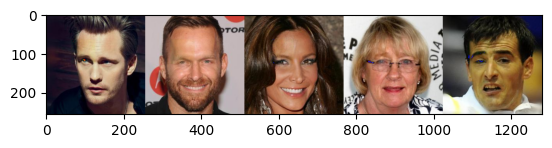

In [22]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, -5:].view([-1, 3, 256, 256]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [23]:
torch.save(model.state_dict(), "model_best.pth")